In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from scipy import interpolate
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from scipy import stats
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.model_selection import train_test_split
from scipy.linalg import norm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm
from pandas import DataFrame
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
# Loading data
path = 'raw/AMZN_stock_market_data.csv'
price_data = pd.read_csv(path, parse_dates = ['Date'])

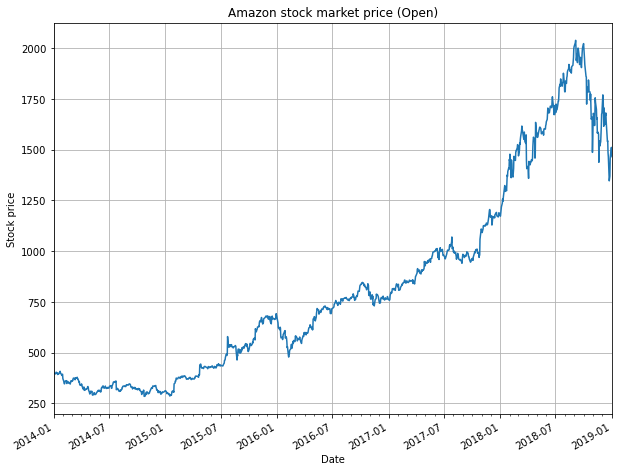

In [4]:
# Plotting open Amazon stock prices 
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=price_data)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


datemin = np.datetime64(price_data.Date.iloc[0], 'Y')
datemax = np.datetime64(price_data.Date.iloc[-1], 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.title('Amazon stock market price (Open)')
plt.xlabel('Date')
plt.ylabel('Stock price') 

plt.show()


### Check for outliers and remove them

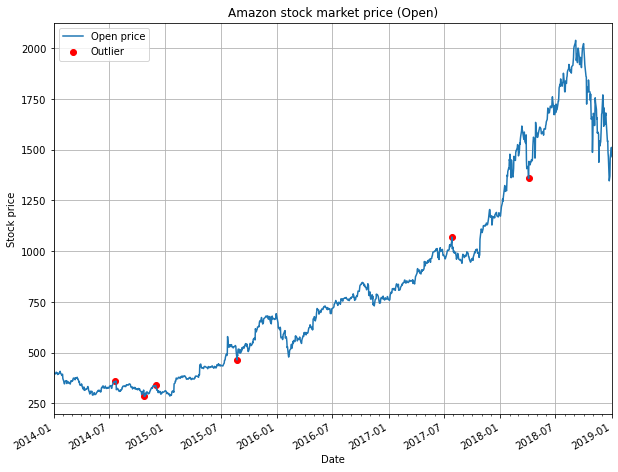

In [5]:
mad_open = price_data.Open.mad()
median_open= price_data.Open.median()

mad = lambda x: np.fabs(x - x.mean()).mean()
price_data['Open_Rolling_mad']=price_data['Open'].rolling(window=60, center=True).apply(mad)
#60-day standard deviation 
price_data['Open_Rolling_Med']=price_data['Open'].rolling(window=60, center=True).median()
#Detect anomalies by determining how far away from the mean (in terms of standard deviation)
#each data point is
price_data['Open_LP_Anomaly']=(abs(price_data.Open - price_data.Open_Rolling_Med)/ price_data.Open_Rolling_mad)>3


# Plotting open Amazon stock prices with outliers
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=price_data)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

datemin = np.datetime64(price_data.Date.iloc[0], 'Y')
datemax = np.datetime64(price_data.Date.iloc[-1], 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.scatter(price_data.Date[price_data['Open_LP_Anomaly']], price_data.Open[price_data['Open_LP_Anomaly']],color='red')

ax.legend(['Open price', 'Outlier'])
plt.title('Amazon stock market price (Open)')
plt.xlabel('Date')
plt.ylabel('Stock price') 

plt.show()


# remove anomalous points
price_data.loc[price_data['Open_LP_Anomaly'],'Open'] = np.nan

# replace missing values via linear interpolation
price_data['Open'] = price_data['Open'].interpolate()

### Seasonal decomposition and checking for stationarity

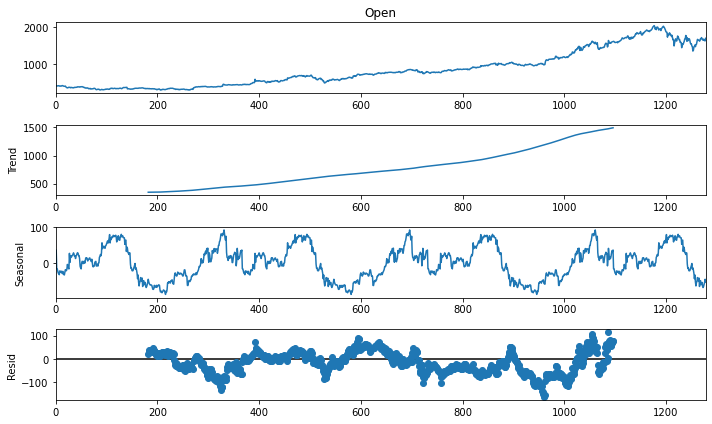

In [6]:
fig = seasonal_decompose(price_data['Open'], model='additive', period=365).plot()

There is clear yearly seasonality and non-stationarity, with obvious upward trend. We run an Augmented Dickey-Fuller (ADF) test to confirm non-stationarity.

In [7]:
dftest = adfuller(price_data['Open'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                    0.213816
p-value                           0.973026
#Lags Used                       22.000000
Number of Observations Used    1256.000000
Critical Value (1%)              -3.435567
Critical Value (5%)              -2.863844
Critical Value (10%)             -2.567997
dtype: float64

We remove the trend by differencing the time series, and check the statistics again:

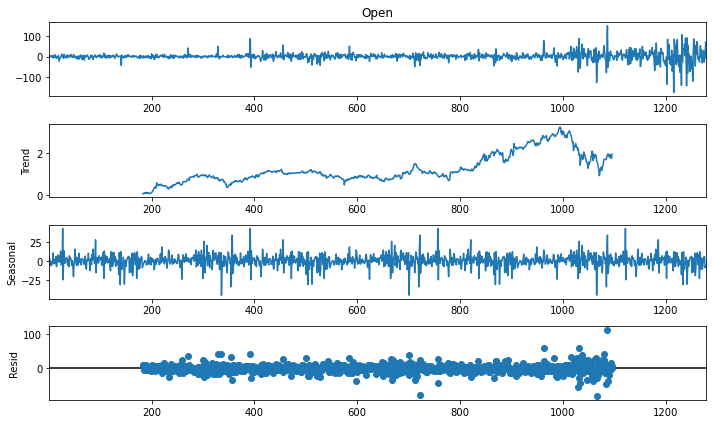

In [8]:
fig = seasonal_decompose(price_data['Open'].diff().dropna(), model='additive', period=365).plot()

In [9]:
dftest = adfuller(price_data['Open'].diff().dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -7.260149e+00
p-value                        1.689854e-10
#Lags Used                     2.100000e+01
Number of Observations Used    1.256000e+03
Critical Value (1%)           -3.435567e+00
Critical Value (5%)           -2.863844e+00
Critical Value (10%)          -2.567997e+00
dtype: float64

After differencing, seasonality was removed, but somewhat of an upward trend remains. However, the ADF test implies that the data is now stationary.

### Plot ACF and PACF

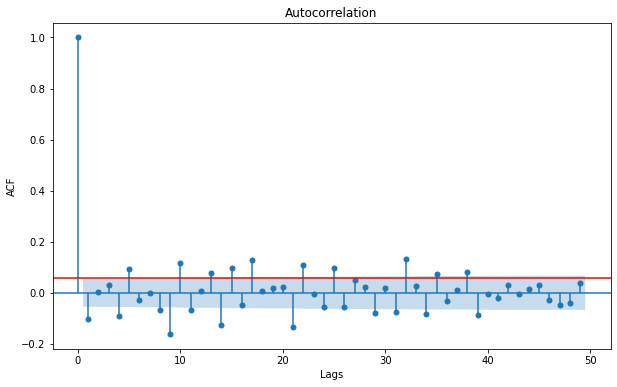

In [10]:
# Plotting autocorrelation function of time-series data
Open_prices=price_data['Open'].diff().dropna()

# Computing critical threshold
thres_ACF=2/np.sqrt(len(Open_prices))

# Plotting autocorrelation function
lags_list=[x for x in range(0,len(Open_prices))]

plot_acf(Open_prices, lags=lags_list[:50])
line = plt.axhline(y=thres_ACF, color='r', linestyle='-')
plt.xlabel('Lags')
plt.ylabel('ACF') 
plt.show()

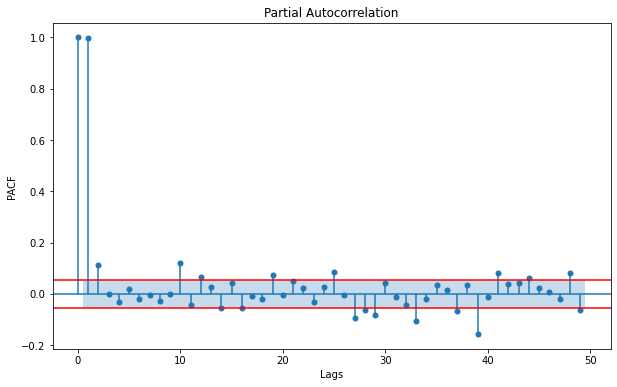

In [11]:
# Plotting partial autocorrelation function of time-series data
Open_prices=price_data['Open'].diff().dropna()

# Computing critical threshold
thres_ACF=2/np.sqrt(len(Open_prices))
n=int(len(Open_prices)/10)  # number of lags

# Loading stock prices
Open_prices=price_data['Open']
lags_list=[x for x in range(0,n)]
plot_pacf(Open_prices, lags=lags_list[:50])
plt.axhline(y=thres_ACF, color='r', linestyle='-')
plt.axhline(y=-thres_ACF, color='r', linestyle='-')
plt.xlabel('Lags')
plt.ylabel('PACF') 
plt.show()


### Build the day-ahead model and forecast

C:\Users\Ana\anaconda3\envs\stock_market\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ana\anaconda3\envs\stock_market\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1022
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3884.422
Date:                Thu, 08 Apr 2021   AIC                           7778.845
Time:                        17:50:27   BIC                           7803.487
Sample:                             0   HQIC                          7788.201
                               - 1022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2683      0.019    -13.859      0.000      -0.306      -0.230
ar.L2         -0.9553      0.023    -41.072      0.000      -1.001      -0.910
ma.L1          0.2584      0.013     19.830      0.0

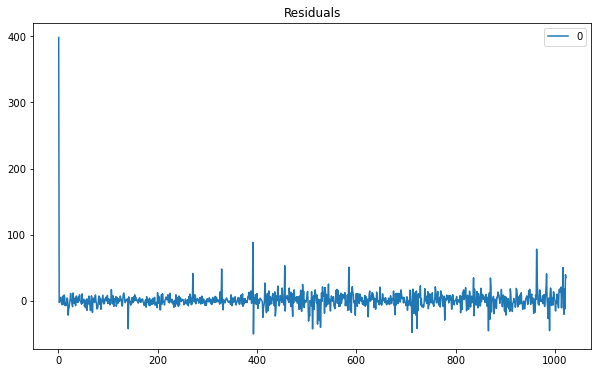

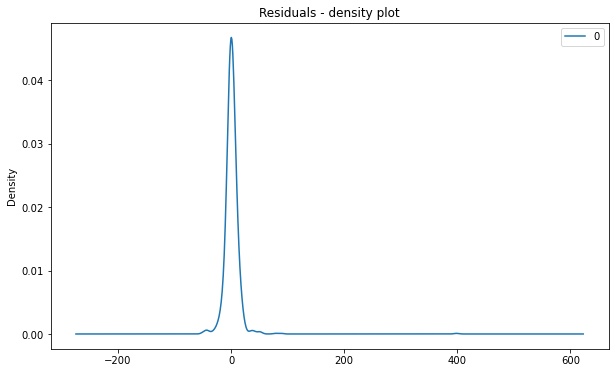

Statistics of the residuals:
                 0
count  1022.000000
mean      1.338022
std      16.480538
min     -50.105274
25%      -4.074037
50%       0.862799
75%       5.936133
max     398.290009


C:\Users\Ana\anaconda3\envs\stock_market\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ana\anaconda3\envs\stock_market\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Ana\anaconda3\envs\stock_market\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Sign accuracy (ARIMA) for next day prices: 0.549
Sign accuracy (Holts-Winters) for next day prices: 0.553
ARIMA: Test RMSE: 40.223
Holts-Winters: Test RMSE: 40.285


In [12]:
# ARIMA forecasting model - next day's stock market price prediction

# Based on the ACF and PACF we define our model as:

q=2   # MA model order
p=2   # AR model order
d=1   # degree of differencing

# Train-test data split
n_train=int(0.80*len(Open_prices))
n_end=len(Open_prices)+1
Open_prices_train=Open_prices.iloc[1:n_train]
Open_prices_test=Open_prices.iloc[n_train:n_end]


# ARIMA - model fit
#fit model
model = ARIMA(Open_prices_train, order=(p,d,q))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title("Residuals")
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals - density plot')
plt.show()

# summary stats of residuals
print('Statistics of the residuals:')
print(residuals.describe())

# Forecasting using the ARIMA model

# ARIMA vs Holts-Winters model performance - predicting next day's stock prices

history = [x for x in Open_prices_train]
# history_holts = [x for x in Open_prices_train]
predictions = list()
predictions_holts = list()

# Rolling forecasting using ARIMA and Holts-Winters (next day's prices)
for t in range(n_train,len(Open_prices)):
    
    #ARIMA Model
    model = ARIMA(history, order=(p,d,q))   
    model_fit = model.fit()                
    yhat = model_fit.forecast()[0]          
    predictions.append(yhat)
    obs = Open_prices_test[t]
    
    # Holts-Winters Simple Exponential Smoothing Model
    model_holts = SimpleExpSmoothing(history).fit()  #Holts winters model
    yhat_holts = model_holts.forecast()[0]
    predictions_holts.append(yhat_holts)
    
    # update history with latest observed value
    history.append(obs)
    
#Computing sign accuracy of ARIMA and Holts-Winters models

results = pd.DataFrame(Open_prices_test)
results['Date'] = price_data.loc[Open_prices_test.index,'Date']
results['returns_actual'] = results.Open.diff().apply(np.sign)
results['preds_ARIMA'] = predictions
results['returns_ARIMA'] = results.preds_ARIMA.diff().apply(np.sign)
results['preds_HW'] = predictions_holts
results['returns_HW'] = results.preds_HW.diff().apply(np.sign)

# drop first line
results = results.dropna()

sig_acc_arima = sum(results.returns_actual == results.returns_ARIMA) / results.shape[0]
sig_acc_hw = sum(results.returns_actual == results.returns_HW) / results.shape[0]

print('Sign accuracy (ARIMA) for next day prices: %.3f' % sig_acc_arima)
print('Sign accuracy (Holts-Winters) for next day prices: %.3f' % sig_acc_hw)


# Evaluating performance of ARIMA model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions))
print('ARIMA: Test RMSE: %.3f' % rmse)

# Evaluating performance of Holts-Winters model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions_holts))
print('Holts-Winters: Test RMSE: %.3f' % rmse)

In [ ]:
# Plotting open Amazon stock prices - Actual vs Predicted
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=results, label='Actual')
ax.plot('Date', 'preds_ARIMA',data=results,  color='red', label='Predicted (ARIMA)')
ax.plot('Date', 'preds_HW', data=results,  color='green', label='Predicted (Holts-Winters)')


# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin = np.datetime64(results.Date.iloc[0], 'Y')
datemax = np.datetime64(results.Date.iloc[-1], 'Y') #+ np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.title('Amazon stock market price (Open)')
plt.xlabel('Date')
plt.ylabel('Stock price') 
plt.legend()

plt.show()


In [ ]:
#ARIMA forecasting model - two days ahead stock market price prediction

q = 2   # MA model order
p = 2   # AR model order
d = 2   # degree of diferencing

# Train-test data split
n_train=int(0.8*len(Open_prices))
n_end=len(Open_prices)+1
Open_prices_train=Open_prices.iloc[1:n_train]
Open_prices_test=Open_prices.iloc[n_train:n_end]


# ARIMA vs Holts-Winters model performance - predicting two days' ahead stock prices
history = [x for x in Open_prices_train]
history.pop() # deleting history's last data point as this is not needed to obtain two days ahead prediction
predictions = list()
predictions_Holts=list()
    
#ARIMA Model (obtaining first prediction using only history data)
history_rolling=history
model_1 = ARIMA(history_rolling, order=(p,d,q))  
model_fit_1 = model_1.fit()                
yhat_1 = model_fit_1.forecast()[0]           

# add one day's ahead prediction to history data in order to predict second day's
history_rolling.append(yhat_1)      
model_2 = ARIMA(history_rolling, order=(p,d,q))  
model_fit_2 = model_2.fit()                
yhat_2 = model_fit_2.forecast()[0]
predictions.append(yhat_2)
history_rolling=[]


#Holts-Winters Model (obtaining first prediction using only history data)
history_rolling_Holts=history
model_holts_1 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
yhat_1_Holts =  model_holts_1.forecast()[0]  

# add one day's ahead prediction to history data in order to predict second day's
history_rolling_Holts.append(yhat_1_Holts)    
model_holts_2 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
yhat_2_Holts = model_holts_2.forecast()[0] 
predictions_Holts.append(yhat_2_Holts)
history_rolling_Holts=[]

# redefining history so that it contains all training data
history = [x for x in Open_prices_train]


# Rolling forecasting using ARIMA and Holts-Winters (Two days ahead prices)
for t in range(n_train,len(Open_prices)):
    
    #ARIMA Model
    history_rolling=history
    model_1 = ARIMA(history_rolling, order=(p,d,q))  
    model_fit_1 = model_1.fit()                
    yhat_1 = model_fit_1.forecast()[0]  
    
    # add one day's ahead prediction to history data in order to predict second day's
    history_rolling.append(yhat_1)
    model_2 = ARIMA(history_rolling, order=(p,d,q))  
    model_fit_2 = model_2.fit()                
    yhat_2 = model_fit_2.forecast()[0]
    predictions.append(yhat_2)
    history_rolling=[]  

   # Holts-Winters Simple Exponential Smoothing Model
    history_rolling_Holts=history
    model_holts_1 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
    yhat_1_Holts =  model_holts_1.forecast()[0]           
    
    # add one day's ahead prediction to history data in order to predict second day's
    history_rolling_Holts.append(yhat_1_Holts)
    model_holts_2 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
    yhat_2_Holts = model_holts_2.forecast()[0] 
    predictions_Holts.append(yhat_2_Holts)
    history_rolling_Holts=[]

    # Appending history using a new data point from test data in order to obtain new forecast in next iteration
    obs = Open_prices_test[t]
    history.append(obs)
    


# Evaluating performance of ARIMA model
predictions.pop()        #so that predictions with ARIMA equal number of points in test data
predictions_Holts.pop()  #so that predictions with Holts-Winters equal number of points in test data

#Computing sign accuracy of ARIMA and Holts-Winters models

results = pd.DataFrame(Open_prices_test)
results['Date'] = price_data.loc[Open_prices_test.index,'Date']
results['returns_actual'] = results.Open.diff().apply(np.sign)
results['preds_ARIMA'] = predictions
results['returns_ARIMA'] = results.preds_ARIMA.diff().apply(np.sign)
results['preds_HW'] = predictions_Holts
results['returns_HW'] = results.preds_HW.diff().apply(np.sign)

# drop first line
results = results.dropna()

sig_acc_arima = sum(results.returns_actual == results.returns_ARIMA) / results.shape[0]
sig_acc_hw = sum(results.returns_actual == results.returns_HW) / results.shape[0]

print('Sign accuracy (ARIMA) for next day prices: %.3f' % sig_acc_arima)
print('Sign accuracy (Holts-Winters) for next day prices: %.3f' % sig_acc_hw)


# Evaluating performance of ARIMA model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions))
print('ARIMA: Test RMSE: %.3f' % rmse)

# Evaluating performance of Holts-Winters model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions_Holts))
print('Holts-Winters: Test RMSE: %.3f' % rmse)

In [ ]:
# Plotting open Amazon stock prices - Actual vs Predicted
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=results, label='Actual')
ax.plot('Date', 'preds_ARIMA',data=results,  color='red', label='Predicted (ARIMA)')
ax.plot('Date', 'preds_HW', data=results,  color='green', label='Predicted (Holts-Winters)')


# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin = np.datetime64(results.Date.iloc[0], 'Y')
datemax = np.datetime64(results.Date.iloc[-1], 'Y') #+ np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.title('Amazon stock market price prediction - 2 days ahead')
plt.xlabel('Date')
plt.ylabel('Stock price') 
plt.legend()

plt.show()
